In [1]:
pip install -r requirements.txt

Looking in indexes: http://pip.modelarts.private.com:8888/repository/pypi/simple
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a8af83cf1be88755d57b9c882bb2668a04dfcdda7be05b81802424dcef30e3c3
  Stored in directory: /home/ma-user/.cache/pip/wheels/c1/b7/16/a5f435ec7bbcf5ec9e56d13a3c2a5765f6e0fc526a02714436
Successfully built rouge_score

[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import math
import time
import random
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.mint as mint
import matplotlib.pyplot as plt

from download import download
from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, print_param_report
from mingpt.bpe import BPETokenizer
from mingpt.lora_inject import inject_lora_into_gpt, attach_lora_optimizer, mark_only_lora_as_trainable
from metrics.perplexity import evaluate_model
from metrics.rouge import eval_rouge
from mindspore.common.initializer import initializer, Normal

[WARNING] ME(6329:281472951853232,MainProcess):2025-10-15-14:38:53.566.593 [mindspore/run_check/_check_version.py:412] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type 

In [3]:
# 华为云端跑的话需要运行这段代码
import os

# 保存原始值（可选，用于后续恢复）
original_rank_table = os.environ.get('RANK_TABLE_FILE')

# 移除环境变量
os.environ.pop('RANK_TABLE_FILE', None)

'/user/config/nbstart_hccl.json'

In [4]:
# 在本地跑可以更换为"CPU"
ms.set_device("Ascend", 0)

[WARNING] ME(6329:281472951853232,MainProcess):2025-10-15-14:39:13.692.374 [mindspore/run_check/_check_version.py:412] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install


# 1.下载数据

In [5]:
# 固定随机种子
set_seed(42)

In [6]:
os.makedirs("data", exist_ok=True)
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O data/input.txt
print("Dataset Shakespeare --> data/input.txt")

--2025-10-15 14:39:16--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving proxy-notebook.modelarts.com (proxy-notebook.modelarts.com)... 192.168.0.33
Connecting to proxy-notebook.modelarts.com (proxy-notebook.modelarts.com)|192.168.0.33|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘data/input.txt’

data/input.txt      100%[===================>]   1.06M  2.17MB/s    in 0.5s    

2025-10-15 14:39:17 (2.17 MB/s) - ‘data/input.txt’ saved [1115394/1115394]

Dataset Shakespeare --> data/input.txt


# 2.数据处理

In [7]:
tok = BPETokenizer()

with open("data/input.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

ids = tok(raw_text).asnumpy()[0].astype(np.int32)   # shape: (T,)
print(f"Total BPE tokens: {len(ids):,}")

# 训练集/验证集切分
val_ratio = 0.1
split = int(len(ids) * (1.0 - val_ratio))
train_ids = ids[:split]
val_ids   = ids[split:]

block_size = 1024

class BPEDataset:
    """把一长串token切成很多(x,y)训练样本；自回归：预测下一个token"""
    def __init__(self, arr, block_size):
        self.arr = arr
        self.block = block_size
    def __len__(self):
        # x: [i, i+block-1], y: [i+1, i+block]
        return max(0, len(self.arr) - self.block - 1)
    def __getitem__(self, idx):
        x = self.arr[idx:idx+self.block]
        y = self.arr[idx+1:idx+1+self.block]
        return ms.Tensor(x, ms.int32), ms.Tensor(y, ms.int32)

train_dataset = BPEDataset(train_ids, block_size)
val_dataset = BPEDataset(val_ids, block_size)

downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json to /home/ma-user/.cache/mingpt/encoder.json
downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe to /home/ma-user/.cache/mingpt/vocab.bpe
Total BPE tokens: 338,025


# 3.模型设置

In [8]:
MODEL_TYPE = 'gpt2'
assert MODEL_TYPE in {'gpt2', 'gpt2-medium', 'gpt2-large'}

# 模型权重下载
url  = f"https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/minGPT/main/media/{MODEL_TYPE}.ckpt"
CKPT_PATH = f"{MODEL_TYPE}.ckpt"
download(url=url, path=CKPT_PATH, replace=False)
print(f"{MODEL_TYPE} 模型权重下载成功 --> {CKPT_PATH}")


file_sizes: 100%|█████████████████████████████| 702M/702M [00:06<00:00, 107MB/s]
Successfully downloaded file to gpt2.ckpt
gpt2 模型权重下载成功 --> gpt2.ckpt


In [9]:
# 模型实例化
C = GPT.get_default_config()
C.model_type  = MODEL_TYPE
C.vocab_size  = 50257
C.block_size  = 1024
C.embd_pdrop = 0.0
C.resid_pdrop = 0.0
C.attn_pdrop  = 0.0
model_full = GPT(C)

# 模型权重加载
param_dict = ms.load_checkpoint(CKPT_PATH)
ms.load_param_into_net(model_full, param_dict)

[WARNING] DEVICE(6329,ffff874f20b0,python):2025-10-15-14:39:37.498.692 [mindspore/ccsrc/plugin/res_manager/ascend/mem_manager/ascend_vmm_adapter.h:150] CheckVmmDriverVersion] Open file /etc/ascend_install.info failed.
[WARNING] DEVICE(6329,ffff874f20b0,python):2025-10-15-14:39:37.498.766 [mindspore/ccsrc/plugin/res_manager/ascend/mem_manager/ascend_vmm_adapter.h:189] CheckVmmDriverVersion] Driver version is less than 24.0.0, vmm is disabled by default, drvier_version: 23.0.6


number of parameters: 124.44M


([],
 ['h.0.attn.bias',
  'h.1.attn.bias',
  'h.2.attn.bias',
  'h.3.attn.bias',
  'h.4.attn.bias',
  'h.5.attn.bias',
  'h.6.attn.bias',
  'h.7.attn.bias',
  'h.8.attn.bias',
  'h.9.attn.bias',
  'h.10.attn.bias',
  'h.11.attn.bias'])

In [10]:
# 模型框架
model_full.trainable_params()[:10]

[Parameter (name=transformer.wte.embedding_table, shape=(50257, 768), dtype=Float32, requires_grad=True),
 Parameter (name=transformer.wpe.embedding_table, shape=(1024, 768), dtype=Float32, requires_grad=True),
 Parameter (name=h.0.ln_1.gamma, shape=(768,), dtype=Float32, requires_grad=True),
 Parameter (name=h.0.ln_1.beta, shape=(768,), dtype=Float32, requires_grad=True),
 Parameter (name=h.0.attn.c_attn.weight, shape=(2304, 768), dtype=Float32, requires_grad=True),
 Parameter (name=h.0.attn.c_attn.bias, shape=(2304,), dtype=Float32, requires_grad=True),
 Parameter (name=h.0.attn.c_proj.weight, shape=(768, 768), dtype=Float32, requires_grad=True),
 Parameter (name=h.0.attn.c_proj.bias, shape=(768,), dtype=Float32, requires_grad=True),
 Parameter (name=h.0.ln_2.gamma, shape=(768,), dtype=Float32, requires_grad=True),
 Parameter (name=h.0.ln_2.beta, shape=(768,), dtype=Float32, requires_grad=True)]

# 4.全参微调

In [11]:
# 训练配置（全参微调）
T_full = Trainer.get_default_config()
T_full.max_iters      = 1000
T_full.batch_size     = 8
T_full.learning_rate  = 3e-5
T_full.weight_decay   = 0.0
T_full.num_workers    = 2

trainer_full = Trainer(T_full, model_full, train_dataset)

iters_full, losses_full = [], []

# 日志输出（每100步）+保存权重（每500步）
os.makedirs("out-ft", exist_ok=True)

def cb(tr):
    if tr.iter_num % 100 == 0:
        print(f"iter:{tr.iter_num:5d} | loss:{tr.loss.asnumpy():.4f} | dt:{tr.iter_dt*1000:.1f}ms")
        iters_full.append(tr.iter_num)
        losses_full.append(float(tr.loss.asnumpy()))
    if tr.iter_num % 500 == 0 and tr.iter_num > 0:
        path = f"out-ft/ft_gpt2_shakespeare_step{tr.iter_num}.ckpt"
        ms.save_checkpoint(model_full, path)
        print(f"Saved step ckpt -> {path}")

trainer_full.add_callback('on_batch_end', cb)

In [12]:
t0_full = time.time()

# 训练（全参数微调）
trainer_full.run()

final_ckpt = "out-ft/ft_gpt2_shakespeare_final.ckpt" 
ms.save_checkpoint(model_full, final_ckpt)
print(f"Saved final ckpt -> {final_ckpt}")

t_full = time.time() - t0_full

....iter:    0 | loss:4.3780 | dt:0.0ms
iter:  100 | loss:3.2363 | dt:750.2ms
iter:  200 | loss:3.1362 | dt:750.5ms
iter:  300 | loss:3.1422 | dt:750.1ms
iter:  400 | loss:2.9106 | dt:750.1ms
iter:  500 | loss:2.8071 | dt:751.3ms
Saved step ckpt -> out-ft/ft_gpt2_shakespeare_step500.ckpt
iter:  600 | loss:2.5307 | dt:750.4ms
iter:  700 | loss:2.3209 | dt:751.0ms
iter:  800 | loss:2.1392 | dt:751.1ms
iter:  900 | loss:1.6978 | dt:751.5ms
Saved final ckpt -> out-ft/ft_gpt2_shakespeare_final.ckpt


# 5.LoRA微调

In [13]:
# 模型实例化
C = GPT.get_default_config()
C.model_type  = MODEL_TYPE
C.vocab_size  = 50257
C.block_size  = 1024
C.embd_pdrop = 0.0
C.resid_pdrop = 0.0
C.attn_pdrop  = 0.0
model_lora = GPT(C)

# 模型权重加载
param_dict = ms.load_checkpoint(CKPT_PATH)
ms.load_param_into_net(model_lora, param_dict)

number of parameters: 124.44M


([],
 ['h.0.attn.bias',
  'h.1.attn.bias',
  'h.2.attn.bias',
  'h.3.attn.bias',
  'h.4.attn.bias',
  'h.5.attn.bias',
  'h.6.attn.bias',
  'h.7.attn.bias',
  'h.8.attn.bias',
  'h.9.attn.bias',
  'h.10.attn.bias',
  'h.11.attn.bias'])

In [14]:
# 加入LoRA层
inject_lora_into_gpt(
    model_lora,
    r=8,
    alpha=8.0,
    dropout=0.0,
    target=("qkv", "attn_out", "mlp"),
    include_lm_head=False
)

# 只训 LoRA
mark_only_lora_as_trainable(model_lora)
attach_lora_optimizer(model_lora)

In [15]:
# 模型框架
model_lora.trainable_params()[:10]

[Parameter (name=c_attn.lora_0.A, shape=(8, 768), dtype=Float32, requires_grad=True),
 Parameter (name=c_attn.lora_0.B, shape=(2304, 8), dtype=Float32, requires_grad=True),
 Parameter (name=c_proj.lora_1.A, shape=(8, 768), dtype=Float32, requires_grad=True),
 Parameter (name=c_proj.lora_1.B, shape=(768, 8), dtype=Float32, requires_grad=True),
 Parameter (name=c_fc.lora_2.A, shape=(8, 768), dtype=Float32, requires_grad=True),
 Parameter (name=c_fc.lora_2.B, shape=(3072, 8), dtype=Float32, requires_grad=True),
 Parameter (name=c_proj.lora_3.A, shape=(8, 3072), dtype=Float32, requires_grad=True),
 Parameter (name=c_proj.lora_3.B, shape=(768, 8), dtype=Float32, requires_grad=True),
 Parameter (name=c_attn.lora_4.A, shape=(8, 768), dtype=Float32, requires_grad=True),
 Parameter (name=c_attn.lora_4.B, shape=(2304, 8), dtype=Float32, requires_grad=True)]

In [16]:
# 训练配置（LoRA参数微调）
T_lora = Trainer.get_default_config()
T_lora.max_iters      = 1000
T_lora.batch_size     = 8
T_lora.learning_rate  = 1e-3
T_lora.weight_decay   = 0.0
T_lora.num_workers    = 2

trainer_lora = Trainer(T_lora, model_lora, train_dataset)

iters_lora, losses_lora = [], []

# 日志输出（每100步）+保存权重（每500步）
os.makedirs("out-lora", exist_ok=True)

def cb(tr):
    if tr.iter_num % 100 == 0:
        print(f"iter:{tr.iter_num:5d} | loss:{tr.loss.asnumpy():.4f} | dt:{tr.iter_dt*1000:.1f}ms")
        iters_lora.append(tr.iter_num)
        losses_lora.append(float(tr.loss.asnumpy()))
    if tr.iter_num % 500 == 0 and tr.iter_num > 0:
        path = f"out-lora/lora_gpt2_shakespeare_step{tr.iter_num}.ckpt"
        ms.save_checkpoint(model_lora, path)
        print(f"Saved step ckpt -> {path}")
        
trainer_lora.add_callback('on_batch_end', cb)

In [17]:
t0_lora = time.time()
# 训练（LoRA微调）
trainer_lora.run()

final_ckpt = "out-lora/lora_gpt2_shakespeare_final.ckpt" 
ms.save_checkpoint(model_lora, final_ckpt)
print(f"Saved final ckpt -> {final_ckpt}")

t_lora = time.time() - t0_lora

..iter:    0 | loss:4.3780 | dt:0.0ms
iter:  100 | loss:3.7110 | dt:740.3ms
iter:  200 | loss:3.6699 | dt:737.8ms
iter:  300 | loss:3.8033 | dt:737.3ms
iter:  400 | loss:3.6413 | dt:737.6ms
iter:  500 | loss:3.6197 | dt:738.6ms
Saved step ckpt -> out-lora/lora_gpt2_shakespeare_step500.ckpt
iter:  600 | loss:3.5676 | dt:738.3ms
iter:  700 | loss:3.6004 | dt:738.0ms
iter:  800 | loss:3.3782 | dt:737.8ms
iter:  900 | loss:3.2281 | dt:737.6ms
Saved final ckpt -> out-lora/lora_gpt2_shakespeare_final.ckpt


# 6.性能对比

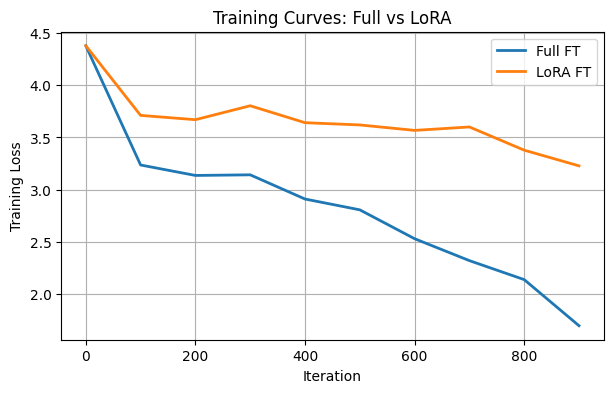

In [18]:
# 学习曲线对比
plt.figure(figsize=(7,4))
plt.plot(iters_full, losses_full, label='Full FT', linewidth=2)
plt.plot(iters_lora, losses_lora, label='LoRA FT', linewidth=2)
plt.xlabel('Iteration'); plt.ylabel('Training Loss')
plt.title('Training Curves: Full vs LoRA')
plt.grid(True); plt.legend()
plt.show()

In [19]:
# 训练时间比较
print(f"Full time = {t_full:.1f}s")
print(f"LoRA time = {t_lora:.1f}s")

Full time = 810.4s
LoRA time = 757.8s


In [20]:
# 训练参数比较
print_param_report("Full Fine-tuning (before LoRA)", model_full)
print_param_report("LoRA Fine-tuning", model_lora)


[Full Fine-tuning (before LoRA)]
Total params        : 163,037,184
Trainable params    : 163,037,184 (100.00%)

[LoRA Fine-tuning]
Total params        : 164,216,832
Trainable params    : 1,179,648 (0.72%)


In [ ]:
# 验证集的loss和困惑度的对比
val_loss_full, val_ppl_full = evaluate_model(model_full, val_dataset, block_size=256, batch_size=8)
val_loss_lora, val_ppl_lora = evaluate_model(model_lora, val_dataset, block_size=256, batch_size=8)

print(f"[Full FT] val_loss={val_loss_full:.4f}, PPL={val_ppl_full:.2f}")
print(f"[LoRA FT] val_loss={val_loss_lora:.4f}, PPL={val_ppl_lora:.2f}")

[Full FT] val_loss=4.5198, PPL=91.81
[LoRA FT] val_loss=3.4557, PPL=31.68


In [ ]:
# 对比ROUGE1（1-gram）,2（2-gram）,L（最长公共子序列）
r1_f, r2_f, rL_f = eval_rouge(model_full, val_ids, tok)
r1_l, r2_l, rL_l = eval_rouge(model_lora, val_ids, tok)

print(f"ROUGE-1 | Full {r1_f:.4f} | LoRA {r1_l:.4f}")
print(f"ROUGE-L | Full {rL_f:.4f} | LoRA {rL_l:.4f}")

ROUGE-1 | Full 0.1644 | LoRA 0.1256
ROUGE-2 | Full 0.0000 | LoRA 0.0135
ROUGE-L | Full 0.1130 | LoRA 0.1140


In [ ]:
# 构建一个基线模型（与微调模型进行对比）
C = GPT.get_default_config()
C.model_type  = MODEL_TYPE
C.vocab_size  = 50257
C.block_size  = 1024
C.embd_pdrop = C.resid_pdrop = C.attn_pdrop = 0.0
model_base = GPT(C)

param_dict = ms.load_checkpoint(CKPT_PATH)
ms.load_param_into_net(model_base, param_dict)

number of parameters: 124.44M


([],
 ['h.0.attn.bias',
  'h.1.attn.bias',
  'h.2.attn.bias',
  'h.3.attn.bias',
  'h.4.attn.bias',
  'h.5.attn.bias',
  'h.6.attn.bias',
  'h.7.attn.bias',
  'h.8.attn.bias',
  'h.9.attn.bias',
  'h.10.attn.bias',
  'h.11.attn.bias'])

In [ ]:
# 随机取验证集里一段上下文
ctx_len, gen_len = 12, 50
pos = random.randint(0, len(val_ids) - ctx_len - gen_len - 2)
ctx_ids = val_ids[pos:pos+ctx_len]
ref_ids = val_ids[pos+ctx_len:pos+ctx_len+gen_len]
x = ms.Tensor([ctx_ids], ms.int32)

# 使用三种模型生成（基线 / 全参微调 / LoRA微调）
y_base = model_base.generate(x, max_new_tokens=gen_len, do_sample=True, top_k=200, temperature=0.9)
y_full = model_full.generate(x, max_new_tokens=gen_len, do_sample=True, top_k=200, temperature=0.9)
y_lora = model_lora.generate(x, max_new_tokens=gen_len, do_sample=True, top_k=200, temperature=0.9)

gen_base = y_base.asnumpy()[0][-gen_len:]
gen_full = y_full.asnumpy()[0][-gen_len:]
gen_lora = y_lora.asnumpy()[0][-gen_len:]

# 解码并打印
prompt_txt = tok.decode(ms.Tensor(ctx_ids, ms.int32))
ref_txt    = tok.decode(ms.Tensor(ref_ids, ms.int32))
base_txt   = tok.decode(ms.Tensor(gen_base, ms.int32))
full_txt   = tok.decode(ms.Tensor(gen_full, ms.int32))
lora_txt   = tok.decode(ms.Tensor(gen_lora, ms.int32))

# 对比结果
print("=== Prompt ===")
print(prompt_txt)
print("\n=== Original Text ===")
print(ref_txt)
print("\n=== Base (pre-finetune) ===")
print(base_txt)
print("\n=== Full Generation ===")
print(full_txt)
print("\n=== LoRA Generation ===")
print(lora_txt)

=== Prompt ===
 I please myself.
The door is open, sir;

=== Original Text ===
 there lies your way;
You may be jogging whiles your boots are green;
For me, I'll not be gone till I please myself:
'Tis like you'll prove a jolly surly groom,
That take

=== Base (pre-finetune) ===
 now is the day when I can fall in love with my cousin.
Oh, how these things do not ruin my heart, friend.
The door stops from the door, and there is darkness and silence in the corridor.
I lay this

=== Full Generation ===
 and I will enter:
What, am I a gentleman? am I a gentleman?

CAPULET:
No.

LADY CAPULET:
I am not a gentleman.

CAPULET:


=== LoRA Generation ===
 my lady, are you close?

MENENIUS:
My.

SICINIUS:
My God, how shall I make a reply?

MENENIUS:
I, I am like one
